1. Data Preprocessing and Feature Engineering

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, log_loss, 
                            matthews_corrcoef, confusion_matrix, 
                            classification_report)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
import joblib
import warnings
warnings.filterwarnings('ignore')

C:\Users\sharv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv(r"E:\Sharvayu data\Malware\.Symbiosis Nagpur SIT\4th SEM\PBL\Dataset\Reduced HateSpeechData-1 final - Copy.csv")

In [6]:
df = df.drop(['sr', 'count'], axis=1)

In [7]:
df = df.drop_duplicates(subset=['tweet'])

In [8]:
df

,hate_speech,offensive_language,neither,class,tweet
0,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...
4994,0,6,0,1,@ThomasNye1 my momma saw how the girls danced ...
4995,0,2,1,1,@ThomasNye1 oh u can dog her out but don't sho...
4996,0,2,1,1,@Thompson_Era so some of Yal bitches need to s...
4997,0,1,2,2,"@Threehoez rip plate, brownies, large tea, fri..."


In [9]:
# Encode target variable
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

# Split data
X = df['tweet']
y = df['class']


In [10]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, stratify=y_train, random_state=42
)


In [11]:
# Check class distribution
print("Training class distribution:")
print(y_train.value_counts(normalize=True))
print("\nValidation class distribution:")
print(y_val.value_counts(normalize=True))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training class distribution:
class
1    0.752787
2    0.169191
0    0.078022
Name: proportion, dtype: float64

Validation class distribution:
class
1    0.752000
2    0.169333
0    0.078667
Name: proportion, dtype: float64

Test class distribution:
class
1    0.753333
2    0.169333
0    0.077333
Name: proportion, dtype: float64


In [12]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)


In [13]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts(normalize=True))


Class distribution after SMOTE:
class
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64


2. Baseline XGBoost Model


Validation Set Evaluation:
Accuracy: 0.8640
Precision (weighted): 0.8737
Recall (weighted): 0.8640
F1 Score (weighted): 0.8668
ROC AUC (OvR): 0.9089
Log Loss: 0.3804
MCC: 0.6845


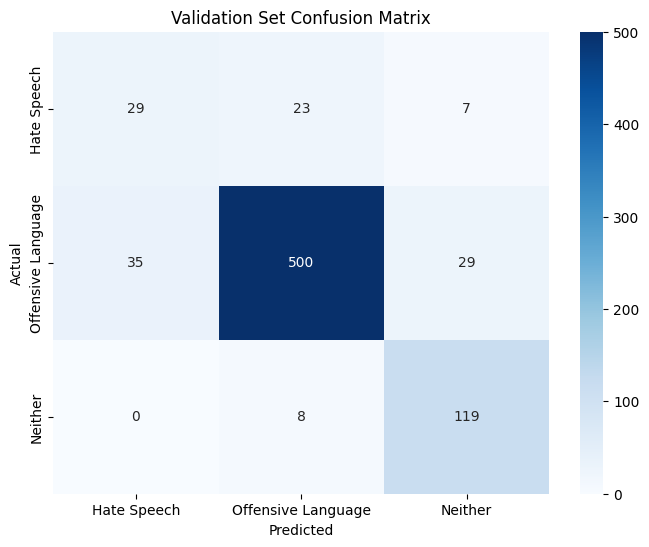


                    precision    recall  f1-score   support

       Hate Speech       0.45      0.49      0.47        59
Offensive Language       0.94      0.89      0.91       564
           Neither       0.77      0.94      0.84       127

          accuracy                           0.86       750
         macro avg       0.72      0.77      0.74       750
      weighted avg       0.87      0.86      0.87       750



In [14]:
# First, let's properly define our class names
class_names = ['Hate Speech', 'Offensive Language', 'Neither']

# Updated evaluation function
def evaluate_model(model, X, y_true, set_name="Validation"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    
    print(f"\n{set_name} Set Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"ROC AUC (OvR): {roc_auc_score(y_true, y_proba, multi_class='ovr'):.4f}")
    print(f"Log Loss: {log_loss(y_true, y_proba):.4f}")
    print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{set_name} Set Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification report
    print(f"\n{classification_report(y_true, y_pred, target_names=class_names)}")

# Re-initialize baseline model with correct parameters
baseline_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    num_class=3  # Important for multi-class classification
)

# Train baseline model
baseline_model.fit(X_train_res, y_train_res)

# Now evaluate with the fixed function
evaluate_model(baseline_model, X_val_tfidf, y_val, "Validation")

3. Hyperparameter Tuning with Optuna

In [15]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2),
    }
    
    model = XGBClassifier(
        **params,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50
    )
    
    # Train with validation set for early stopping
    model.fit(
        X_train_res, 
        y_train_res,
        eval_set=[(X_val_tfidf, y_val)],  # Validation set for early stopping
        verbose=0  # Turn off training logs
    )
    
    # Get best iteration score
    best_score = model.best_score
    return best_score

# Optimize study
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50, timeout=3600)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(f"  Validation Score: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-25 14:37:27,976] A new study created in memory with name: no-name-05340199-68ff-424a-9d49-5a796031e19f
[I 2025-04-25 14:38:03,709] Trial 0 finished with value: 0.3813861518609338 and parameters: {'learning_rate': 0.03574712922600244, 'n_estimators': 956, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.07800932022121826, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088, 'scale_pos_weight': 1.5621088666940683}. Best is trial 0 with value: 0.3813861518609338.
[I 2025-04-25 14:38:56,912] Trial 1 finished with value: 0.4035361441982289 and parameters: {'learning_rate': 0.010725209743171996, 'n_estimators': 973, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.09091248360355031, 'subsample': 0.7550213529560301, 'colsample_bytree': 0.7912726728878613, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'scale_pos_weight': 0.9368437102970628}. Best is trial 1 with value: 0.40

Best trial:
  Validation Score: 0.6688
  Params: 
    learning_rate: 0.013008200601957889
    n_estimators: 221
    max_depth: 3
    min_child_weight: 5
    gamma: 0.21785460918988608
    subsample: 0.7947343170556123
    colsample_bytree: 0.7540316022193432
    reg_alpha: 0.38489470974882767
    reg_lambda: 0.7270124884143547
    scale_pos_weight: 1.3015340521420191


[0]	validation_0-mlogloss:1.09515
[10]	validation_0-mlogloss:1.04662
[20]	validation_0-mlogloss:1.00906
[30]	validation_0-mlogloss:0.97183
[40]	validation_0-mlogloss:0.93796
[50]	validation_0-mlogloss:0.90821
[60]	validation_0-mlogloss:0.88245
[70]	validation_0-mlogloss:0.85669
[80]	validation_0-mlogloss:0.83539
[90]	validation_0-mlogloss:0.81550
[100]	validation_0-mlogloss:0.79770
[110]	validation_0-mlogloss:0.78050
[120]	validation_0-mlogloss:0.76586
[130]	validation_0-mlogloss:0.75197
[140]	validation_0-mlogloss:0.73923
[150]	validation_0-mlogloss:0.72816
[160]	validation_0-mlogloss:0.71694
[170]	validation_0-mlogloss:0.70737
[180]	validation_0-mlogloss:0.69841
[190]	validation_0-mlogloss:0.69054
[200]	validation_0-mlogloss:0.68270
[210]	validation_0-mlogloss:0.67535
[220]	validation_0-mlogloss:0.66881

Final Model Evaluation:

Validation Set Evaluation:
Accuracy: 0.7760
Precision (weighted): 0.8494
Recall (weighted): 0.7760
F1 Score (weighted): 0.7915
ROC AUC (OvR): 0.8793
Log Loss

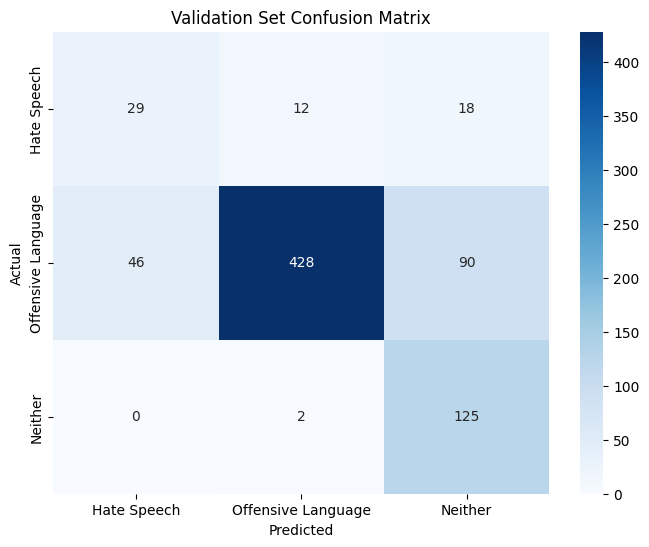


                    precision    recall  f1-score   support

       Hate Speech       0.39      0.49      0.43        59
Offensive Language       0.97      0.76      0.85       564
           Neither       0.54      0.98      0.69       127

          accuracy                           0.78       750
         macro avg       0.63      0.74      0.66       750
      weighted avg       0.85      0.78      0.79       750


Test Set Evaluation:
Accuracy: 0.7693
Precision (weighted): 0.8568
Recall (weighted): 0.7693
F1 Score (weighted): 0.7879
ROC AUC (OvR): 0.8844
Log Loss: 0.6853
MCC: 0.5852


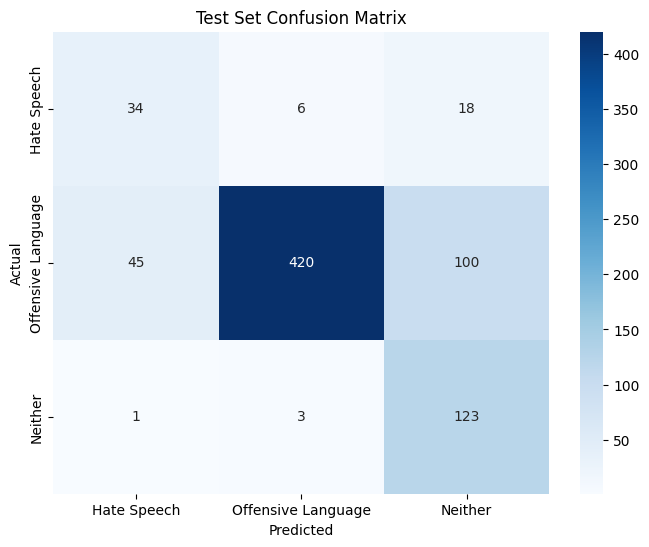


                    precision    recall  f1-score   support

       Hate Speech       0.42      0.59      0.49        58
Offensive Language       0.98      0.74      0.85       565
           Neither       0.51      0.97      0.67       127

          accuracy                           0.77       750
         macro avg       0.64      0.77      0.67       750
      weighted avg       0.86      0.77      0.79       750



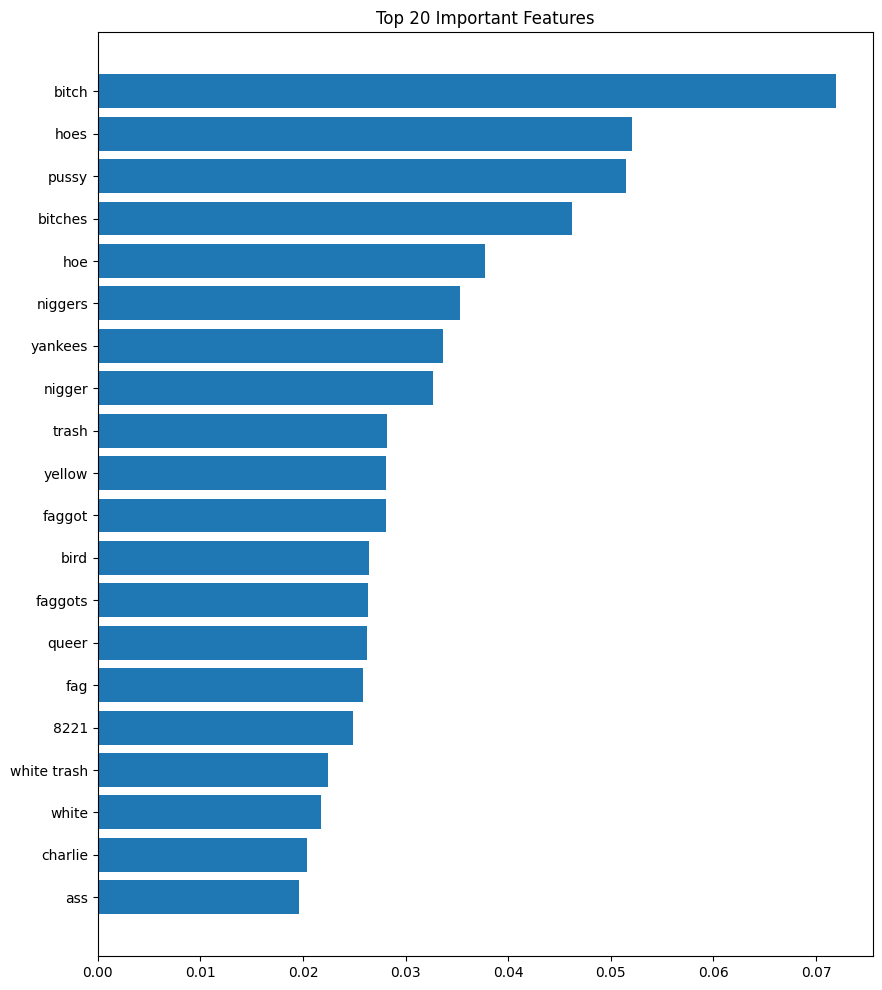

In [17]:
# Train final model with best parameters
best_params = study.best_params

final_model = XGBClassifier(
    **best_params,
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # Moved from fit() to here
)

# Train with early stopping
final_model.fit(
    X_train_res, 
    y_train_res,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=10
)

# Evaluate final model
print("\nFinal Model Evaluation:")
evaluate_model(final_model, X_val_tfidf, y_val, "Validation")
evaluate_model(final_model, X_test_tfidf, y_test, "Test")

# Feature importance
plt.figure(figsize=(10, 12))
sorted_idx = final_model.feature_importances_.argsort()
plt.barh(
    np.array(tfidf.get_feature_names_out())[sorted_idx][-20:],
    final_model.feature_importances_[sorted_idx][-20:]
)
plt.title("Top 20 Important Features")
plt.show()

In [19]:
# Create a pipeline that includes both TF-IDF and XGBoost
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('xgb', final_model)
])

# Save the pipeline
joblib.dump(pipeline, 'hate_speech_xgb_pipeline.joblib')
joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

In [20]:
# Load and test the pipeline
loaded_pipeline = joblib.load('hate_speech_xgb_pipeline.joblib')
loaded_le = joblib.load('label_encoder.joblib')

In [21]:

# Test prediction
sample_texts = [
    "I hate those people, they should all die",  # Hate speech
    "This is fucking ridiculous",  # Offensive language
    "I enjoy walking in the park on sunny days"  # Neither
]

predictions = loaded_pipeline.predict(sample_texts)
probabilities = loaded_pipeline.predict_proba(sample_texts)

print("\nSample Predictions:")
for text, pred, prob in zip(sample_texts, predictions, probabilities):
    print(f"\nText: {text}")
    print(f"Predicted class: {loaded_le.classes_[pred]}")
    print("Class probabilities:")
    for class_name, p in zip(loaded_le.classes_, prob):
        print(f"  {class_name}: {p:.4f}")


Sample Predictions:

Text: I hate those people, they should all die
Predicted class: 2
Class probabilities:
  0: 0.3038
  1: 0.2298
  2: 0.4665

Text: This is fucking ridiculous
Predicted class: 2
Class probabilities:
  0: 0.3038
  1: 0.2298
  2: 0.4665

Text: I enjoy walking in the park on sunny days
Predicted class: 2
Class probabilities:
  0: 0.3038
  1: 0.2298
  2: 0.4665


In [24]:
# User Input Prediction Function - Fixed Version
import numpy as np
from sklearn.pipeline import Pipeline

def predict_hate_speech():
    # Load the saved pipeline
    try:
        pipeline = joblib.load('hate_speech_xgb_pipeline.joblib')
        print("\nModel loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return
    
    print("\nHate Speech Detection System")
    print("Type 'quit' to exit\n")
    
    while True:
        user_input = input("Enter text to analyze: ").strip()
        
        if user_input.lower() == 'quit':
            print("Exiting...")
            break
            
        if not user_input:
            print("Please enter some text.")
            continue
            
        try:
            # Get prediction probabilities
            proba = pipeline.predict_proba([user_input])[0]
            prediction = pipeline.predict([user_input])[0]
            
            print("\n" + "="*50)
            print(f"Input Text: {user_input}")
            print("="*50)
            
            # Display prediction results
            print("\nPrediction Results:")
            print(f"Predicted Class: {class_names[prediction]}")
            print("\nClass Probabilities:")
            for cls, prob in zip(class_names, proba):
                print(f"{cls}: {prob:.4f}")
            
            # Show explanation (simplified version)
            print("\nKey Words Influencing Prediction:")
            explain_prediction_simple(user_input, pipeline)
            print("\n" + "="*50 + "\n")
            
        except Exception as e:
            print(f"Error processing input: {str(e)}")

def explain_prediction_simple(text, pipeline):
    """Simplified explanation without SHAP for reliability"""
    try:
        # Get feature names from TF-IDF
        tfidf = pipeline.named_steps['tfidf']
        features = tfidf.get_feature_names_out()
        
        # Get important words from the text
        words = [word.lower() for word in text.split()]
        important_words = [word for word in words if word in features]
        
        # Just show the words that exist in our vocabulary
        if important_words:
            print(", ".join(important_words[:10]))  # Show up to 10 words
        else:
            print("No known significant words detected")
            
    except Exception as e:
        print(f"Could not generate explanation: {str(e)}")

# Run the prediction interface
predict_hate_speech()


Model loaded successfully!

Hate Speech Detection System
Type 'quit' to exit


Input Text: hello beatiful

Prediction Results:
Predicted Class: Neither

Class Probabilities:
Hate Speech: 0.3038
Offensive Language: 0.2298
Neither: 0.4665

Key Words Influencing Prediction:
hello



Input Text: you dumb ass

Prediction Results:
Predicted Class: Hate Speech

Class Probabilities:
Hate Speech: 0.3697
Offensive Language: 0.2796
Neither: 0.3507

Key Words Influencing Prediction:
dumb, ass



Input Text: fuck you son of a bitch

Prediction Results:
Predicted Class: Offensive Language

Class Probabilities:
Hate Speech: 0.1520
Offensive Language: 0.7925
Neither: 0.0556

Key Words Influencing Prediction:
fuck, son, bitch


Exiting...


#END MODEL SAVING AND LOADING 

In [25]:
# ML MODEL SAVING AND LOADING - BY FORMAT
# =======================================

import os
import pickle
import joblib
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
import h5py
import torch
import torch.nn as nn
import onnx
import onnxruntime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import traceback

# Create directory for saved models
os.makedirs("saved_models", exist_ok=True)

# Sample data for demonstration
np.random.seed(42)
X_train = np.random.rand(100, 10)
y_train = np.random.randint(0, 2, size=100)
X_test = np.random.rand(20, 10)

# ------------------------------------------------
# 1. PICKLE FORMAT (.pkl)
# ------------------------------------------------

# --- SAVING WITH PICKLE ---
def save_model_pickle():
    print("\n=== SAVING MODEL WITH PICKLE ===")
    try:
        # Train a simple sklearn model
        sklearn_model = RandomForestClassifier(n_estimators=10)
        sklearn_model.fit(X_train, y_train)
        
        # Save with pickle
        with open("saved_models/model_pickle.pkl", "wb") as f:
            pickle.dump(sklearn_model, f)
        print("Model saved to 'saved_models/model_pickle.pkl'")
        return sklearn_model
    except Exception as e:
        print(f"Error saving pickle model: {e}")
        return None

# --- LOADING WITH PICKLE ---
def load_model_pickle():
    print("\n=== LOADING MODEL FROM PICKLE ===")
    try:
        # Load the model
        with open("saved_models/model_pickle.pkl", "rb") as f:
            loaded_model = pickle.load(f)
        
        # Verify model works
        predictions = loaded_model.predict(X_test[:3])
        print(f"Loaded model predictions: {predictions}")
        return loaded_model
    except Exception as e:
        print(f"Error loading pickle model: {e}")
        return None

# ------------------------------------------------
# 2. JOBLIB FORMAT (.joblib)
# ------------------------------------------------

# --- SAVING WITH JOBLIB ---
def save_model_joblib():
    print("\n=== SAVING MODEL WITH JOBLIB ===")
    try:
        # Train a simple sklearn model
        sklearn_model = RandomForestClassifier(n_estimators=10)
        sklearn_model.fit(X_train, y_train)
        
        # Save with joblib
        joblib.dump(sklearn_model, "saved_models/model.joblib")
        print("Model saved to 'saved_models/model.joblib'")
        return sklearn_model
    except Exception as e:
        print(f"Error saving joblib model: {e}")
        return None

# --- LOADING WITH JOBLIB ---
def load_model_joblib():
    print("\n=== LOADING MODEL FROM JOBLIB ===")
    try:
        # Load the model
        loaded_model = joblib.load("saved_models/model.joblib")
        
        # Verify model works
        predictions = loaded_model.predict(X_test[:3])
        print(f"Loaded model predictions: {predictions}")
        return loaded_model
    except Exception as e:
        print(f"Error loading joblib model: {e}")
        return None

# ------------------------------------------------
# 3. KERAS HDF5 FORMAT (.h5)
# ------------------------------------------------

# --- SAVING KERAS MODEL AS HDF5 ---
def save_keras_h5():
    print("\n=== SAVING KERAS MODEL AS HDF5 ===")
    try:
        # Create and train a simple Keras model
        model = keras.Sequential([
            keras.layers.Dense(16, activation='relu', input_shape=(10,)),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=3, verbose=0)
        
        # Save the model in HDF5 format
        model.save("saved_models/keras_model.h5")
        print("Keras model saved to 'saved_models/keras_model.h5'")
        return model
    except Exception as e:
        print(f"Error saving Keras H5 model: {e}")
        return None

# --- LOADING KERAS MODEL FROM HDF5 ---
def load_keras_h5():
    print("\n=== LOADING KERAS MODEL FROM HDF5 ===")
    try:
        # Load the model
        loaded_model = keras.models.load_model("saved_models/keras_model.h5")
        
        # Verify model works
        predictions = loaded_model.predict(X_test[:3])
        print(f"Loaded model predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions[:3].flatten()}")
        return loaded_model
    except Exception as e:
        print(f"Error loading Keras H5 model: {e}")
        return None

# ------------------------------------------------
# 4. KERAS SAVEDMODEL FORMAT
# ------------------------------------------------

# --- SAVING KERAS MODEL AS SAVEDMODEL ---
def save_keras_savedmodel():
    print("\n=== SAVING KERAS MODEL WITH SAVEDMODEL FORMAT ===")
    try:
        # Create and train a simple Keras model
        model = keras.Sequential([
            keras.layers.Dense(16, activation='relu', input_shape=(10,)),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=3, verbose=0)
        
        # Try multiple approaches for compatibility with different Keras versions
        try:
            # For Keras 3.x
            model.save("saved_models/keras_savedmodel.keras")
            savedmodel_path = "saved_models/keras_savedmodel.keras"
            print("Keras model saved to 'saved_models/keras_savedmodel.keras'")
        except Exception as e1:
            try:
                # For older TensorFlow/Keras versions
                tf.saved_model.save(model, "saved_models/keras_savedmodel_tf")
                savedmodel_path = "saved_models/keras_savedmodel_tf"
                print("Keras model saved to 'saved_models/keras_savedmodel_tf' directory")
            except Exception as e2:
                # Try export method
                try:
                    model.export("saved_models/keras_savedmodel_export")
                    savedmodel_path = "saved_models/keras_savedmodel_export"
                    print("Keras model saved to 'saved_models/keras_savedmodel_export' directory")
                except Exception as e3:
                    print(f"Failed all SavedModel approaches: {e1}, {e2}, {e3}")
                    raise Exception("Could not save using any SavedModel method")
        
        return model, savedmodel_path
    except Exception as e:
        print(f"Error saving Keras SavedModel: {e}")
        return None, None

# --- LOADING KERAS MODEL FROM SAVEDMODEL ---
def load_keras_savedmodel(path):
    print("\n=== LOADING KERAS MODEL FROM SAVEDMODEL ===")
    try:
        # Try multiple approaches for compatibility
        try:
            # Standard approach
            loaded_model = keras.models.load_model(path)
        except Exception as e1:
            try:
                # TensorFlow SavedModel approach
                loaded_model = tf.saved_model.load(path)
            except Exception as e2:
                print(f"Failed to load SavedModel: {e1}, {e2}")
                raise Exception("Could not load using any SavedModel method")
        
        # Verify model works if it's a Keras model
        if hasattr(loaded_model, 'predict'):
            predictions = loaded_model.predict(X_test[:3])
            print(f"Loaded model predictions shape: {predictions.shape}")
            print(f"First few predictions: {predictions[:3].flatten()}")
        else:
            print("Loaded model is not a standard Keras model with predict() method")
        
        return loaded_model
    except Exception as e:
        print(f"Error loading Keras SavedModel: {e}")
        return None

# ------------------------------------------------
# 5. KERAS WEIGHTS ONLY (.h5)
# ------------------------------------------------

# --- SAVING KERAS WEIGHTS ONLY ---
def save_keras_weights():
    print("\n=== SAVING KERAS WEIGHTS ONLY ===")
    try:
        # Create and train a simple Keras model
        model = keras.Sequential([
            keras.layers.Dense(16, activation='relu', input_shape=(10,)),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy')
        model.fit(X_train, y_train, epochs=3, verbose=0)
        
        # Save only the weights
        model.save_weights("saved_models/keras_weights.h5")
        print("Keras weights saved to 'saved_models/keras_weights.h5'")
        return model
    except Exception as e:
        print(f"Error saving Keras weights: {e}")
        return None

# --- LOADING KERAS WEIGHTS ONLY ---
def load_keras_weights():
    print("\n=== LOADING KERAS WEIGHTS ONLY ===")
    try:
        # Create model with same architecture
        new_model = keras.Sequential([
            keras.layers.Dense(16, activation='relu', input_shape=(10,)),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        # Load weights into the model
        new_model.compile(optimizer='adam', loss='binary_crossentropy')
        new_model.load_weights("saved_models/keras_weights.h5")
        
        # Verify model works
        predictions = new_model.predict(X_test[:3])
        print(f"Loaded model predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions[:3].flatten()}")
        return new_model
    except Exception as e:
        print(f"Error loading Keras weights: {e}")
        return None

# ------------------------------------------------
# 6. PYTORCH FULL MODEL (.pt)
# ------------------------------------------------

# Define PyTorch model class once
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# --- SAVING PYTORCH FULL MODEL ---
def save_pytorch_model():
    print("\n=== SAVING PYTORCH FULL MODEL ===")
    try:
        # Create and train PyTorch model
        model = SimpleNN()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        # Convert data to PyTorch tensors
        X_torch = torch.FloatTensor(X_train)
        y_torch = torch.FloatTensor(y_train.reshape(-1, 1))
        
        # Quick training
        for epoch in range(3):
            optimizer.zero_grad()
            outputs = model(X_torch)
            loss = criterion(outputs, y_torch)
            loss.backward()
            optimizer.step()
        
        # Save the complete model
        torch.save(model, "saved_models/full_torch_model.pt")
        print("PyTorch model saved to 'saved_models/full_torch_model.pt'")
        return model
    except Exception as e:
        print(f"Error saving PyTorch model: {e}")
        return None

# --- LOADING PYTORCH FULL MODEL ---
def load_pytorch_model():
    print("\n=== LOADING PYTORCH FULL MODEL ===")
    try:
        # Load the model
        loaded_model = torch.load("saved_models/full_torch_model.pt")
        loaded_model.eval()  # Set to evaluation mode
        
        # Verify model works
        X_test_torch = torch.FloatTensor(X_test[:3])
        with torch.no_grad():
            predictions = loaded_model(X_test_torch)
        
        print(f"Loaded model predictions: {predictions.numpy().flatten()}")
        return loaded_model
    except Exception as e:
        print(f"Error loading PyTorch model: {e}")
        return None

# ------------------------------------------------
# 7. PYTORCH STATE DICT (.pt)
# ------------------------------------------------

# --- SAVING PYTORCH STATE DICT ---
def save_pytorch_state_dict():
    print("\n=== SAVING PYTORCH STATE DICTIONARY ===")
    try:
        # Create and train PyTorch model
        model = SimpleNN()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        # Convert data to PyTorch tensors
        X_torch = torch.FloatTensor(X_train)
        y_torch = torch.FloatTensor(y_train.reshape(-1, 1))
        
        # Quick training
        for epoch in range(3):
            optimizer.zero_grad()
            outputs = model(X_torch)
            loss = criterion(outputs, y_torch)
            loss.backward()
            optimizer.step()
        
        # Save just the state dictionary
        torch.save(model.state_dict(), "saved_models/torch_state_dict.pt")
        print("PyTorch state dict saved to 'saved_models/torch_state_dict.pt'")
        return model
    except Exception as e:
        print(f"Error saving PyTorch state dict: {e}")
        return None

# --- LOADING PYTORCH STATE DICT ---
def load_pytorch_state_dict():
    print("\n=== LOADING PYTORCH STATE DICTIONARY ===")
    try:
        # Create model with same architecture
        model = SimpleNN()
        
        # Load state dictionary
        model.load_state_dict(torch.load("saved_models/torch_state_dict.pt"))
        model.eval()  # Set to evaluation mode
        
        # Verify model works
        X_test_torch = torch.FloatTensor(X_test[:3])
        with torch.no_grad():
            predictions = model(X_test_torch)
        
        print(f"Loaded model predictions: {predictions.numpy().flatten()}")
        return model
    except Exception as e:
        print(f"Error loading PyTorch state dict: {e}")
        return None

# ------------------------------------------------
# 8. ONNX FORMAT
# ------------------------------------------------

# --- SAVING MODEL TO ONNX ---
def save_model_onnx():
    print("\n=== SAVING MODEL TO ONNX FORMAT ===")
    try:
        # Create and train PyTorch model
        model = SimpleNN()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        # Convert data to PyTorch tensors
        X_torch = torch.FloatTensor(X_train)
        y_torch = torch.FloatTensor(y_train.reshape(-1, 1))
        
        # Quick training
        for epoch in range(3):
            optimizer.zero_grad()
            outputs = model(X_torch)
            loss = criterion(outputs, y_torch)
            loss.backward()
            optimizer.step()
        
        # Export to ONNX
        dummy_input = torch.randn(1, 10)
        torch.onnx.export(model, dummy_input, "saved_models/model.onnx",
                         export_params=True, opset_version=10,
                         input_names=['input'], output_names=['output'])
        
        print("Model saved to ONNX format at 'saved_models/model.onnx'")
        return model
    except Exception as e:
        print(f"Error saving ONNX model: {e}")
        return None

# --- LOADING AND USING ONNX MODEL ---
def load_model_onnx():
    print("\n=== LOADING AND USING ONNX MODEL ===")
    try:
        # Load ONNX model
        onnx_model = onnx.load("saved_models/model.onnx")
        onnx.checker.check_model(onnx_model)
        
        # Create inference session
        ort_session = onnxruntime.InferenceSession("saved_models/model.onnx")
        
        # Run inference
        test_input = {ort_session.get_inputs()[0].name: X_test[:3].astype(np.float32)}
        predictions = ort_session.run(None, test_input)
        
        print(f"ONNX model predictions shape: {predictions[0].shape}")
        print(f"First few predictions: {predictions[0].flatten()}")
        return ort_session
    except Exception as e:
        print(f"Error loading ONNX model: {e}")
        return None

# ------------------------------------------------
# 9. CUSTOM JSON FORMAT
# ------------------------------------------------

# --- SAVING MODEL PARAMETERS AS JSON ---
def save_model_json():
    print("\n=== SAVING MODEL PARAMETERS AS JSON ===")
    try:
        # Create and train a logistic regression model
        model = LogisticRegression()
        model.fit(X_train, y_train)
        
        # Extract model parameters
        model_params = {
            "weights": model.coef_.tolist(),
            "bias": model.intercept_.tolist(),
            "classes": model.classes_.tolist()
        }
        
        # Save as JSON
        with open("saved_models/custom_model_params.json", "w") as f:
            json.dump(model_params, f)
        
        print("Model parameters saved to 'saved_models/custom_model_params.json'")
        return model
    except Exception as e:
        print(f"Error saving JSON model: {e}")
        return None

# --- LOADING AND USING JSON PARAMETERS ---
def load_model_json():
    print("\n=== LOADING MODEL PARAMETERS FROM JSON ===")
    try:
        # Load parameters
        with open("saved_models/custom_model_params.json", "r") as f:
            params = json.load(f)
        
        # Create a new logistic regression model
        model = LogisticRegression()
        
        # Manually initialize with loaded parameters
        # Note: This is simplified; in practice you might need to do more
        model.coef_ = np.array(params["weights"])
        model.intercept_ = np.array(params["bias"])
        model.classes_ = np.array(params["classes"])
        
        # Model needs to be "fitted" before prediction
        # This is a workaround for sklearn models
        model._fitted = True
        
        # Try to make predictions (may not work perfectly with this simple approach)
        try:
            predictions = model.predict(X_test[:3])
            print(f"Loaded model predictions: {predictions}")
        except Exception as e:
            print(f"Prediction failed: {e}")
            print("Note: Rebuilding models from JSON requires more setup")
        
        print(f"Loaded parameters - first few weights: {params['weights'][0][:3]}")
        return model
    except Exception as e:
        print(f"Error loading JSON model: {e}")
        return None

# ------------------------------------------------
# EXAMPLE USAGE
# ------------------------------------------------

def main():
    print("ML MODEL SAVING AND LOADING EXAMPLES")
    print("====================================")
    
    # Track successful methods
    successful_methods = []
    
    try:
        # PICKLE
        original_pickle_model = save_model_pickle()
        if original_pickle_model is not None:
            loaded_pickle_model = load_model_pickle()
            if loaded_pickle_model is not None:
                successful_methods.append("PICKLE")
    except Exception as e:
        print(f"Error in pickle section: {e}")
    
    try:
        # JOBLIB
        original_joblib_model = save_model_joblib()
        if original_joblib_model is not None:
            loaded_joblib_model = load_model_joblib()
            if loaded_joblib_model is not None:
                successful_methods.append("JOBLIB")
    except Exception as e:
        print(f"Error in joblib section: {e}")
    
    try:
        # KERAS H5
        original_keras_h5 = save_keras_h5()
        if original_keras_h5 is not None:
            loaded_keras_h5 = load_keras_h5()
            if loaded_keras_h5 is not None:
                successful_methods.append("KERAS H5")
    except Exception as e:
        print(f"Error in Keras H5 section: {e}")
    
    try:
        # KERAS SAVEDMODEL
        original_keras_savedmodel, savedmodel_path = save_keras_savedmodel()
        if original_keras_savedmodel is not None and savedmodel_path is not None:
            loaded_keras_savedmodel = load_keras_savedmodel(savedmodel_path)
            if loaded_keras_savedmodel is not None:
                successful_methods.append("KERAS SAVEDMODEL")
    except Exception as e:
        print(f"Error in Keras SavedModel section: {e}")
    
    try:
        # KERAS WEIGHTS
        original_keras_weights = save_keras_weights()
        if original_keras_weights is not None:
            loaded_keras_weights = load_keras_weights()
            if loaded_keras_weights is not None:
                successful_methods.append("KERAS WEIGHTS")
    except Exception as e:
        print(f"Error in Keras weights section: {e}")
    
    try:
        # PYTORCH FULL MODEL
        original_pytorch_model = save_pytorch_model()
        if original_pytorch_model is not None:
            loaded_pytorch_model = load_pytorch_model()
            if loaded_pytorch_model is not None:
                successful_methods.append("PYTORCH FULL MODEL")
    except Exception as e:
        print(f"Error in PyTorch full model section: {e}")
    
    try:
        # PYTORCH STATE DICT
        original_pytorch_state_dict = save_pytorch_state_dict()
        if original_pytorch_state_dict is not None:
            loaded_pytorch_state_dict = load_pytorch_state_dict()
            if loaded_pytorch_state_dict is not None:
                successful_methods.append("PYTORCH STATE DICT")
    except Exception as e:
        print(f"Error in PyTorch state dict section: {e}")
    
    try:
        # ONNX
        original_onnx_model = save_model_onnx()
        if original_onnx_model is not None:
            loaded_onnx_session = load_model_onnx()
            if loaded_onnx_session is not None:
                successful_methods.append("ONNX")
    except Exception as e:
        print(f"Error in ONNX section: {e}")
    
    try:
        # JSON
        original_json_model = save_model_json()
        if original_json_model is not None:
            loaded_json_model = load_model_json()
            if loaded_json_model is not None:
                successful_methods.append("JSON")
    except Exception as e:
        print(f"Error in JSON section: {e}")
    
    # Summary
    print("\n=== SUMMARY ===")
    print(f"Successfully demonstrated {len(successful_methods)} saving/loading methods:")
    for i, method in enumerate(successful_methods, 1):
        print(f"{i}. {method}")
    
    if len(successful_methods) < 9:
        print(f"\nSome methods failed. Check the output above for error messages.")
    else:
        print("\nAll methods completed successfully!")

if __name__ == "__main__":
    main()

ML MODEL SAVING AND LOADING EXAMPLES

=== SAVING MODEL WITH PICKLE ===
Model saved to 'saved_models/model_pickle.pkl'

=== LOADING MODEL FROM PICKLE ===
Loaded model predictions: [1 0 1]

=== SAVING MODEL WITH JOBLIB ===
Model saved to 'saved_models/model.joblib'

=== LOADING MODEL FROM JOBLIB ===
Loaded model predictions: [1 0 1]

=== SAVING KERAS MODEL AS HDF5 ===


Keras model saved to 'saved_models/keras_model.h5'

=== LOADING KERAS MODEL FROM HDF5 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Loaded model predictions shape: (3, 1)
First few predictions: [0.54358643 0.5183184  0.48999995]

=== SAVING KERAS MODEL WITH SAVEDMODEL FORMAT ===
Keras model saved to 'saved_models/keras_savedmodel.keras'

=== LOADING KERAS MODEL FROM SAVEDMODEL ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Loaded model predictions shape: (3, 1)
First few predictions: [0.41920102 0.48187122 0.45935914]

=== SAVING KERAS WEIGHTS ONLY ===
Error saving Keras weights: The filename must end in `.weights.h5`. Received: filepath=saved_models/keras_weights.h5

=== SAVING PYTORCH FULL MODEL ===
PyTorch model saved to 'saved_models/full_torch_model.pt'

=== LOADING PYTORCH FULL MODEL ===
Error loading PyTorch model: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, w

In [1]:
# ML MODEL LOADING - BY FORMAT
# ===========================

import os
import pickle
import joblib
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import onnx
import onnxruntime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Sample data for testing loaded models
np.random.seed(42)
X_test = np.random.rand(20, 10)

print("ML MODEL LOADING FUNCTIONS")
print("=========================")

# ------------------------------------------------
# 1. LOADING FROM PICKLE (.pkl)
# ------------------------------------------------

def load_from_pickle(filepath="saved_models/model_pickle.pkl"):
    """
    Load a machine learning model from a pickle file.
    
    Args:
        filepath: Path to the pickle file
        
    Returns:
        The loaded model
    """
    print("\n=== LOADING MODEL FROM PICKLE ===")
    try:
        # Load the model
        with open(filepath, "rb") as f:
            loaded_model = pickle.load(f)
        
        # Show model type
        print(f"Model type: {type(loaded_model).__name__}")
        
        # Try to get predictions if possible
        try:
            predictions = loaded_model.predict(X_test[:3])
            print(f"Test predictions: {predictions}")
        except:
            print("Could not generate test predictions")
            
        return loaded_model
    except Exception as e:
        print(f"Error loading pickle model: {e}")
        return None

# ------------------------------------------------
# 2. LOADING FROM JOBLIB (.joblib)
# ------------------------------------------------

def load_from_joblib(filepath="saved_models/model.joblib"):
    """
    Load a machine learning model from a joblib file.
    
    Args:
        filepath: Path to the joblib file
        
    Returns:
        The loaded model
    """
    print("\n=== LOADING MODEL FROM JOBLIB ===")
    try:
        # Load the model
        loaded_model = joblib.load(filepath)
        
        # Show model type
        print(f"Model type: {type(loaded_model).__name__}")
        
        # Try to get predictions if possible
        try:
            predictions = loaded_model.predict(X_test[:3])
            print(f"Test predictions: {predictions}")
        except:
            print("Could not generate test predictions") 
            
        return loaded_model
    except Exception as e:
        print(f"Error loading joblib model: {e}")
        return None

# ------------------------------------------------
# 3. LOADING FROM KERAS HDF5 (.h5)
# ------------------------------------------------

def load_from_keras_h5(filepath="saved_models/keras_model.h5"):
    """
    Load a Keras model from HDF5 format.
    
    Args:
        filepath: Path to the H5 file
        
    Returns:
        The loaded Keras model
    """
    print("\n=== LOADING KERAS MODEL FROM HDF5 ===")
    try:
        # Load the model
        loaded_model = keras.models.load_model(filepath)
        
        # Show model summary
        print("Model architecture:")
        loaded_model.summary(print_fn=lambda x: print(f"  {x}"))
        
        # Try to get predictions
        predictions = loaded_model.predict(X_test[:3])
        print(f"Test predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions[:3].flatten()}")
        
        return loaded_model
    except Exception as e:
        print(f"Error loading Keras H5 model: {e}")
        return None

# ------------------------------------------------
# 4. LOADING FROM KERAS SAVEDMODEL
# ------------------------------------------------

def load_from_keras_savedmodel(filepath="saved_models/keras_savedmodel"):
    """
    Load a Keras model from SavedModel format (directory or .keras file).
    
    Args:
        filepath: Path to the SavedModel directory or .keras file
        
    Returns:
        The loaded Keras model
    """
    print("\n=== LOADING KERAS MODEL FROM SAVEDMODEL FORMAT ===")
    try:
        # Try multiple approaches for compatibility with different Keras versions
        try:
            # Standard approach
            loaded_model = keras.models.load_model(filepath)
            print(f"Loaded model using keras.models.load_model")
        except Exception as e1:
            try:
                # TensorFlow SavedModel approach
                loaded_model = tf.saved_model.load(filepath)
                print(f"Loaded model using tf.saved_model.load")
            except Exception as e2:
                print(f"Failed to load SavedModel: {e1}, {e2}")
                raise Exception("Could not load with any method")
        
        # Show model information if available
        if hasattr(loaded_model, 'summary'):
            print("Model architecture:")
            loaded_model.summary(print_fn=lambda x: print(f"  {x}"))
        else:
            print("Model loaded but summary not available")
        
        # Try to get predictions if possible
        if hasattr(loaded_model, 'predict'):
            predictions = loaded_model.predict(X_test[:3])
            print(f"Test predictions shape: {predictions.shape}")
            print(f"First few predictions: {predictions[:3].flatten()}")
        else:
            print("Model does not have predict() method")
            
        return loaded_model
    except Exception as e:
        print(f"Error loading Keras SavedModel: {e}")
        return None

# ------------------------------------------------
# 5. LOADING KERAS WEIGHTS ONLY
# ------------------------------------------------

def load_from_keras_weights(filepath="saved_models/keras_weights.h5"):
    """
    Load Keras weights into a model with matching architecture.
    
    Args:
        filepath: Path to the weights file
        
    Returns:
        The model with loaded weights
    """
    print("\n=== LOADING KERAS WEIGHTS ONLY ===")
    try:
        # Create a model with the same architecture
        new_model = keras.Sequential([
            keras.layers.Dense(16, activation='relu', input_shape=(10,)),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        
        # Compile the model
        new_model.compile(optimizer='adam', loss='binary_crossentropy')
        
        # Load weights
        new_model.load_weights(filepath)
        print("Weights loaded successfully")
        
        # Show model summary
        print("Model architecture:")
        new_model.summary(print_fn=lambda x: print(f"  {x}"))
        
        # Try to get predictions
        predictions = new_model.predict(X_test[:3])
        print(f"Test predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions[:3].flatten()}")
        
        return new_model
    except Exception as e:
        print(f"Error loading Keras weights: {e}")
        return None

# ------------------------------------------------
# 6. LOADING FULL PYTORCH MODEL
# ------------------------------------------------

def load_from_pytorch_full(filepath="saved_models/full_torch_model.pt"):
    """
    Load a complete PyTorch model.
    
    Args:
        filepath: Path to the PyTorch model file
        
    Returns:
        The loaded PyTorch model
    """
    print("\n=== LOADING FULL PYTORCH MODEL ===")
    try:
        # Load the model
        loaded_model = torch.load(filepath)
        loaded_model.eval()  # Set to evaluation mode
        
        # Show model structure
        print(f"Model architecture: {loaded_model}")
        
        # Try to get predictions
        X_test_torch = torch.FloatTensor(X_test[:3])
        with torch.no_grad():
            predictions = loaded_model(X_test_torch)
        
        print(f"Test predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions.numpy().flatten()}")
        
        return loaded_model
    except Exception as e:
        print(f"Error loading PyTorch model: {e}")
        return None

# ------------------------------------------------
# 7. LOADING PYTORCH STATE DICT
# ------------------------------------------------

# Define the model architecture to load state dict into
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

def load_from_pytorch_state_dict(filepath="saved_models/torch_state_dict.pt"):
    """
    Load a PyTorch model from state dictionary.
    
    Args:
        filepath: Path to the state dict file
        
    Returns:
        The model with loaded state dict
    """
    print("\n=== LOADING PYTORCH STATE DICTIONARY ===")
    try:
        # Create model with the matching architecture
        model = SimpleNN()
        
        # Load state dictionary
        model.load_state_dict(torch.load(filepath))
        model.eval()  # Set to evaluation mode
        
        print("State dictionary loaded successfully")
        print(f"Model architecture: {model}")
        
        # Try to get predictions
        X_test_torch = torch.FloatTensor(X_test[:3])
        with torch.no_grad():
            predictions = model(X_test_torch)
        
        print(f"Test predictions shape: {predictions.shape}")
        print(f"First few predictions: {predictions.numpy().flatten()}")
        
        return model
    except Exception as e:
        print(f"Error loading PyTorch state dict: {e}")
        return None

# ------------------------------------------------
# 8. LOADING FROM ONNX FORMAT
# ------------------------------------------------

def load_from_onnx(filepath="saved_models/model.onnx"):
    """
    Load and use a model in ONNX format.
    
    Args:
        filepath: Path to the ONNX file
        
    Returns:
        The ONNX inference session
    """
    print("\n=== LOADING AND USING ONNX MODEL ===")
    try:
        # Load ONNX model
        onnx_model = onnx.load(filepath)
        onnx.checker.check_model(onnx_model)
        print("ONNX model loaded and checked")
        
        # Show model info
        print(f"Model IR version: {onnx_model.ir_version}")
        print(f"Producer name: {onnx_model.producer_name}")
        
        # Create inference session
        ort_session = onnxruntime.InferenceSession(filepath)
        
        # Get input name
        input_name = ort_session.get_inputs()[0].name
        print(f"Input name: {input_name}")
        
        # Run inference
        test_input = {input_name: X_test[:3].astype(np.float32)}
        predictions = ort_session.run(None, test_input)
        
        print(f"Test predictions shape: {predictions[0].shape}")
        print(f"First few predictions: {predictions[0].flatten()}")
        
        return ort_session
    except Exception as e:
        print(f"Error loading ONNX model: {e}")
        return None

# ------------------------------------------------
# 9. LOADING FROM CUSTOM JSON
# ------------------------------------------------

def load_from_json(filepath="saved_models/custom_model_params.json"):
    """
    Load model parameters from a JSON file.
    
    Args:
        filepath: Path to the JSON file
        
    Returns:
        A model reconstructed from the parameters
    """
    print("\n=== LOADING MODEL PARAMETERS FROM JSON ===")
    try:
        # Load the parameters
        with open(filepath, "r") as f:
            params = json.load(f)
        
        print("JSON parameters loaded successfully")
        print(f"Parameter keys: {list(params.keys())}")
        
        # Create a new model
        # This example uses LogisticRegression, but would depend on what was saved
        model = LogisticRegression()
        
        # Manually initialize the model with loaded parameters
        model.coef_ = np.array(params["weights"])
        model.intercept_ = np.array(params["bias"])
        model.classes_ = np.array(params["classes"])
        
        # Set the model as fitted
        model._fitted = True
        
        # Show some parameter info
        print(f"Weight shape: {model.coef_.shape}")
        print(f"First few weights: {model.coef_[0][:5]}")
        
        # Try to make predictions
        try:
            predictions = model.predict(X_test[:3])
            print(f"Test predictions: {predictions}")
        except Exception as e:
            print(f"Prediction failed: {e}")
            print("Note: Rebuilding models from JSON can require more setup")
        
        return model
    except Exception as e:
        print(f"Error loading JSON model: {e}")
        return None

# ------------------------------------------------
# DEMONSTRATION
# ------------------------------------------------

def demonstrate_model_loading():
    """Run examples of all model loading functions"""
    
    # Dictionary of loading functions
    loading_functions = {
        "1. Pickle": load_from_pickle,
        "2. Joblib": load_from_joblib,
        "3. Keras H5": load_from_keras_h5,
        "4. Keras SavedModel": load_from_keras_savedmodel,
        "5. Keras Weights": load_from_keras_weights,
        "6. PyTorch Full Model": load_from_pytorch_full,
        "7. PyTorch State Dict": load_from_pytorch_state_dict,
        "8. ONNX": load_from_onnx,
        "9. JSON": load_from_json
    }
    
    # Print available options
    print("\nAvailable model loading functions:")
    for name in loading_functions.keys():
        print(f"  {name}")
    
    print("\nTo load a model, call any of the functions above.")
    print("Example usage:")
    print("  model = load_from_pickle('path/to/your/model.pkl')")
    print("  model = load_from_keras_h5('path/to/your/model.h5')")

# Run the demonstration if this script is executed directly
if __name__ == "__main__":
    demonstrate_model_loading()

ML MODEL LOADING FUNCTIONS

Available model loading functions:
  1. Pickle
  2. Joblib
  3. Keras H5
  4. Keras SavedModel
  5. Keras Weights
  6. PyTorch Full Model
  7. PyTorch State Dict
  8. ONNX
  9. JSON

To load a model, call any of the functions above.
Example usage:
  model = load_from_pickle('path/to/your/model.pkl')
  model = load_from_keras_h5('path/to/your/model.h5')


In [3]:
# Hate Speech Detection Terminal Interface
import joblib
import numpy as np

# Define class labels (adjust as per your training data)
class_names = ['Non-Hate Speech', 'Hate Speech']

def predict_hate_speech():
    # Load the saved pipeline
    try:
        pipeline = joblib.load('hate_speech_xgb_pipeline.joblib')
        print("\nModel loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return
    
    print("\nHate Speech Detection System")
    print("Type 'quit' to exit\n")
    
    while True:
        user_input = input("Enter text to analyze: ").strip()
        
        if user_input.lower() == 'quit':
            print("Exiting...")
            break
            
        if not user_input:
            print("Please enter some text.")
            continue
            
        try:
            # Get prediction probabilities and label
            proba = pipeline.predict_proba([user_input])[0]
            prediction = pipeline.predict([user_input])[0]
            
            print("\n" + "="*50)
            print(f"Input Text: {user_input}")
            print("="*50)
            
            # Display prediction results
            print("\nPrediction Results:")
            print(f"Predicted Class: {class_names[prediction]}")
            print("\nClass Probabilities:")
            for cls, prob in zip(class_names, proba):
                print(f"{cls}: {prob:.4f}")
            
            # Show explanation (simplified version)
            print("\nKey Words Influencing Prediction:")
            explain_prediction_simple(user_input, pipeline)
            print("\n" + "="*50 + "\n")
            
        except Exception as e:
            print(f"Error processing input: {str(e)}")

def explain_prediction_simple(text, pipeline):
    """Simplified explanation without SHAP for reliability"""
    try:
        # Get feature names from TF-IDF
        tfidf = pipeline.named_steps['tfidf']
        features = tfidf.get_feature_names_out()
        
        # Get important words from the input text
        words = [word.lower() for word in text.split()]
        important_words = [word for word in words if word in features]
        
        if important_words:
            print(", ".join(important_words[:10]))  # Show up to 10 words
        else:
            print("No known significant words detected")
            
    except Exception as e:
        print(f"Could not generate explanation: {str(e)}")

# Run the prediction interface
predict_hate_speech()



Model loaded successfully!

Hate Speech Detection System
Type 'quit' to exit


Input Text: hello beautiful

Prediction Results:
Error processing input: list index out of range

Input Text: you look ugly

Prediction Results:
Error processing input: list index out of range
Exiting...


In [25]:
import joblib
import gradio as gr
import numpy as np

# Load model and class names
pipeline = joblib.load("hate_speech_xgb_pipeline.joblib")

# Define the mapping of class indices to meaningful labels
class_names = ['Hate Speech', 'Offensive Language', 'Neither']

def classify_text(text):
    # Predict class and probabilities
    prediction = pipeline.predict([text])[0]
    proba = pipeline.predict_proba([text])[0]

    # Map prediction index to meaningful label
    prediction_label = class_names[int(prediction)]  # Map index to label

    # Format the class probabilities for display
    probability_str = "\n".join(f"{cls}: {p:.4f}" for cls, p in zip(class_names, proba))

    # Extract important words from text that are in TF-IDF vocabulary
    tfidf = pipeline.named_steps['tfidf']
    features = tfidf.get_feature_names_out()
    words = [word.lower() for word in text.split()]
    important_words = [word for word in words if word in features]
    important_words_str = ", ".join(important_words[:10]) if important_words else "No significant words found"

    return prediction_label, probability_str, important_words_str

# Define the Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=3, placeholder="Enter text here..."),
    outputs=[
        gr.Label(label="Predicted Class"),
        gr.Textbox(label="Class Probabilities"),
        gr.Textbox(label="Important Words")
    ],
    title="Hate Speech Detection",
    description="Enter a sentence to check for hate speech"
)

# Launch the interface
iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
